In [1]:
import pandas as pd

# Load the dataset
file_path = 'adult_cleaned.csv'
df = pd.read_csv(file_path)

# Show the first few rows of the dataset to understand its structure
df.head()


age   workclass  fnlwgt     education  education.num marital.status  \
0   90  NotDefined   77053       HS-grad              9        Widowed   
1   82     Private  132870       HS-grad              9        Widowed   
2   66  NotDefined  186061  Some-college             10        Widowed   
3   54     Private  140359       7th-8th              4       Divorced   
4   41     Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0            Missing  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2            Missing      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

In [2]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encodedvalue = LabelEncoder()

# Create a new dataframe to store the label-encoded data
encodedframe = df.copy()

# Perform label encoding on each categorical column
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
for col in categorical_columns:
    encodedframe[col] = encodedvalue.fit_transform(df[col])

# Show the first few rows of the encoded dataframe
encodedframe.head()


age  workclass  fnlwgt  education  education.num  marital.status  \
0   90          3   77053         11              9               6   
1   82          4  132870         11              9               6   
2   66          3  186061         15             10               6   
3   54          4  140359          5              4               0   
4   41          4  264663         15             10               5   

   occupation  relationship  race  sex  capital.gain  capital.loss  \
0           7             1     4    0             0          4356   
1           3             1     4    0             0          4356   
2           7             4     2    0             0          4356   
3           6             4     4    0             0          3900   
4          10             3     4    0             0          3900   

   hours.per.week  native.country  income  
0              40              39       0  
1              18              39       0  
2              40              39       0  
3              40              39       0  
4              40              39       0

In [3]:
from sklearn.model_selection import train_test_split

# Separate the features and target variable
X = encodedframe.drop('income', axis=1)
y = encodedframe['income']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the shape of the resulting sets
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)


(((26029, 14), (6508, 14)), ((26029,), (6508,)))

In [ ]:
# RFE 

In [4]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)

# Initialize RFE
selector = RFE(estimator=classifier, step=1)

# Fit RFE
selector = selector.fit(X_train, y_train)

# Get the ranking of features
feature_ranking = selector.ranking_

# Create a DataFrame to hold feature names and their ranking
feature_ranking_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': feature_ranking
}).sort_values(by='Ranking')

# Show the feature ranking
feature_ranking_df


Feature  Ranking
0              age        1
2           fnlwgt        1
4    education.num        1
6       occupation        1
7     relationship        1
10    capital.gain        1
12  hours.per.week        1
11    capital.loss        2
1        workclass        3
13  native.country        4
3        education        5
8             race        6
5   marital.status        7
9              sex        8

In [ ]:
    # age
    # fnlwgt
    # education.num
    # occupation
    # relationship
    # capital.gain
    # hours.per.week

In [5]:
# Select the top-ranked features based on RFE results
top_features = feature_ranking_df[feature_ranking_df['Ranking'] == 1]['Feature'].tolist()

# Update the training and testing sets to only include these top features
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]

# Show the first few rows of the updated training set with top features
X_train_top_features.head()


age  fnlwgt  education.num  occupation  relationship  capital.gain  \
32216   41   64506              9           4             0             0   
30356   29  211482             13          12             0             0   
5455    43  196945              9           8             0             0   
19691   46  282538             11           6             1             0   
23182   30  100734             10           0             5             0   

       hours.per.week  
32216              50  
30356              40  
5455               78  
19691              40  
23182              40

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Initialize metrics storage
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
}

# Perform k-fold cross-validation and evaluate metrics
for name, clf in classifiers.items():
    # Perform k-fold cross-validation
    cross_val_scores = cross_val_score(clf, X_train_top_features, y_train, cv=5)
    cross_val_mean = cross_val_scores.mean()
    
    # Train the model
    clf.fit(X_train_top_features, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test_top_features)
    y_prob = clf.predict_proba(X_test_top_features)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Calculate performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    # Store metrics
    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc)
    metrics['Precision'].append(prec)
    metrics['Recall'].append(rec)
    metrics['F1 Score'].append(f1)
    metrics['ROC AUC'].append(roc_auc)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics)

metrics_df


Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.799017   0.786486  0.191447  0.307937  0.538370
1                  SVM  0.798709   0.964602  0.143421  0.249714  0.597586
2        Random Forest  0.845882   0.688274  0.621711  0.653301  0.895188
3          Naive Bayes  0.795329   0.709821  0.209211  0.323171  0.824424

In [ ]:
# PLOTTING GRAPH ON THIS 

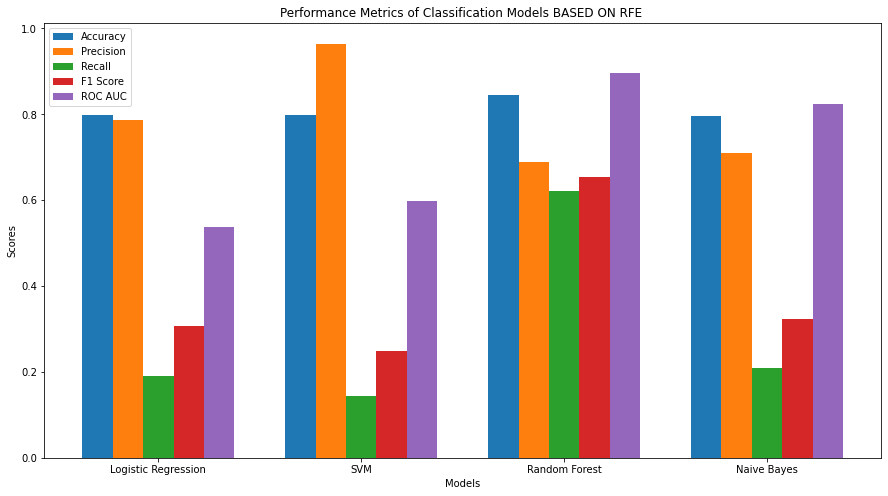

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Create an index for each tick position
ind = np.arange(len(metrics['Model']))

# Create the bar plot for each metric
bar_width = 0.15
b1 = ax.bar(ind - 2*bar_width, metrics['Accuracy'], bar_width, label='Accuracy')
b2 = ax.bar(ind - bar_width, metrics['Precision'], bar_width, label='Precision')
b3 = ax.bar(ind, metrics['Recall'], bar_width, label='Recall')
b4 = ax.bar(ind + bar_width, [f if f != 'N/A' else 0 for f in metrics['F1 Score']], bar_width, label='F1 Score')
b5 = ax.bar(ind + 2*bar_width, [r if r != 'N/A' else 0 for r in metrics['ROC AUC']], bar_width, label='ROC AUC')

# Describe the data
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Classification Models BASED ON RFE ')
ax.set_xticks(ind)
ax.set_xticklabels(metrics['Model'])
ax.legend()

# Show the bar plot
plt.show()


In [ ]:
# WITH ALL FEATURES 

In [8]:
# Initialize metrics storage for all features
all_features_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
}

# Perform k-fold cross-validation and evaluate metrics using all features
for name, clf in classifiers.items():
    # Perform k-fold cross-validation
    cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
    cross_val_mean = cross_val_scores.mean()
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Calculate performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    # Store metrics
    all_features_metrics['Model'].append(name)
    all_features_metrics['Accuracy'].append(acc)
    all_features_metrics['Precision'].append(prec)
    all_features_metrics['Recall'].append(rec)
    all_features_metrics['F1 Score'].append(f1)
    all_features_metrics['ROC AUC'].append(roc_auc)

# Create a DataFrame to display the metrics
all_features_metrics_df = pd.DataFrame(all_features_metrics)

all_features_metrics_df


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.791334   0.619469  0.276316  0.382166  0.729428
1                  SVM  0.798556   0.968610  0.142105  0.247849  0.626521
2        Random Forest  0.859250   0.728442  0.633553  0.677692  0.906193
3          Naive Bayes  0.797326   0.640167  0.301974  0.410371  0.823993

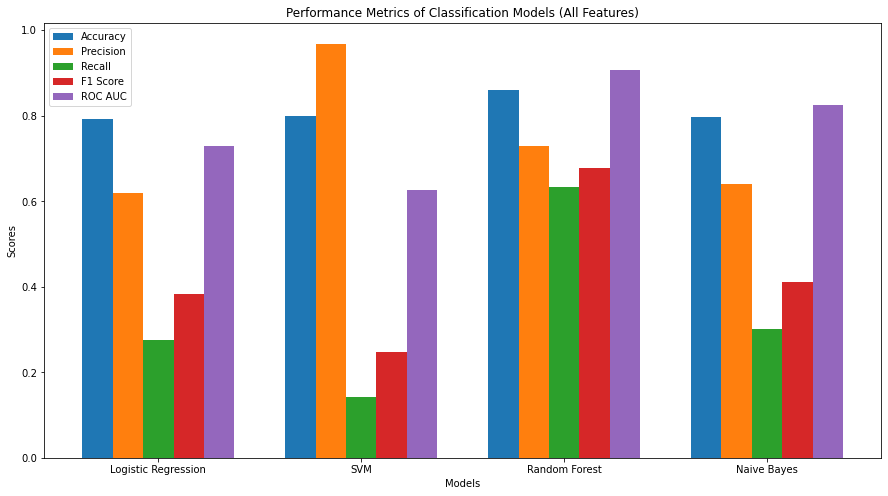

In [9]:
# plotting the graph 
# Set up the figure and axis for all features metrics
fig, ax = plt.subplots(figsize=(15, 8))

# Create an index for each tick position
ind = np.arange(len(all_features_metrics['Model']))

# Create the bar plot for each metric
bar_width = 0.15
b1 = ax.bar(ind - 2*bar_width, all_features_metrics['Accuracy'], bar_width, label='Accuracy')
b2 = ax.bar(ind - bar_width, all_features_metrics['Precision'], bar_width, label='Precision')
b3 = ax.bar(ind, all_features_metrics['Recall'], bar_width, label='Recall')
b4 = ax.bar(ind + bar_width, [f if f != 'N/A' else 0 for f in all_features_metrics['F1 Score']], bar_width, label='F1 Score')
b5 = ax.bar(ind + 2*bar_width, [r if r != 'N/A' else 0 for r in all_features_metrics['ROC AUC']], bar_width, label='ROC AUC')

# Describe the data
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Classification Models (All Features)')
ax.set_xticks(ind)
ax.set_xticklabels(all_features_metrics['Model'])
ax.legend()

# Show the bar plot
plt.show()


In [ ]:
# Forward selection 

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize the Logistic Regression Classifier
logistic_clf = LogisticRegression(random_state=42)

# Initialize Forward Feature Selector using Logistic Regression and based on accuracy
sfs = SFS(estimator=logistic_clf, 
          k_features='best',
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5)

# Fit the forward feature selector
sfs = sfs.fit(X_train, y_train)

# Get the best features
best_features = list(sfs.k_feature_names_)

best_features


In [ ]:
# ['education.num',
#  'relationship',
#  'sex',
#  'capital.gain',
#  'capital.loss',
#  'native.country']

In [ ]:
# Training the model here 

In [15]:
# Initialize metrics storage for forward selected features
forward_selected_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
}

# Update the training and testing sets to include only the forward selected features
X_train_forward = X_train[best_features]
X_test_forward = X_test[best_features]

# Perform k-fold cross-validation and evaluate metrics using forward selected features
for name, clf in classifiers.items():
    # Perform k-fold cross-validation
    cross_val_scores = cross_val_score(clf, X_train_forward, y_train, cv=5)
    cross_val_mean = cross_val_scores.mean()
    
    # Train the model
    clf.fit(X_train_forward, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test_forward)
    y_prob = clf.predict_proba(X_test_forward)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Calculate performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    # Store metrics
    forward_selected_metrics['Model'].append(name)
    forward_selected_metrics['Accuracy'].append(acc)
    forward_selected_metrics['Precision'].append(prec)
    forward_selected_metrics['Recall'].append(rec)
    forward_selected_metrics['F1 Score'].append(f1)
    forward_selected_metrics['ROC AUC'].append(roc_auc)

# Create a DataFrame to display the metrics
forward_selected_metrics_df = pd.DataFrame(forward_selected_metrics)

forward_selected_metrics_df


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.824985   0.751651  0.374342  0.499780  0.805413
1                  SVM  0.805624   0.731397  0.265132  0.389184  0.811829
2        Random Forest  0.861862   0.775510  0.575000  0.660370  0.903529
3          Naive Bayes  0.798095   0.645892  0.300000  0.409704  0.811964

In [ ]:
# plotting graph 


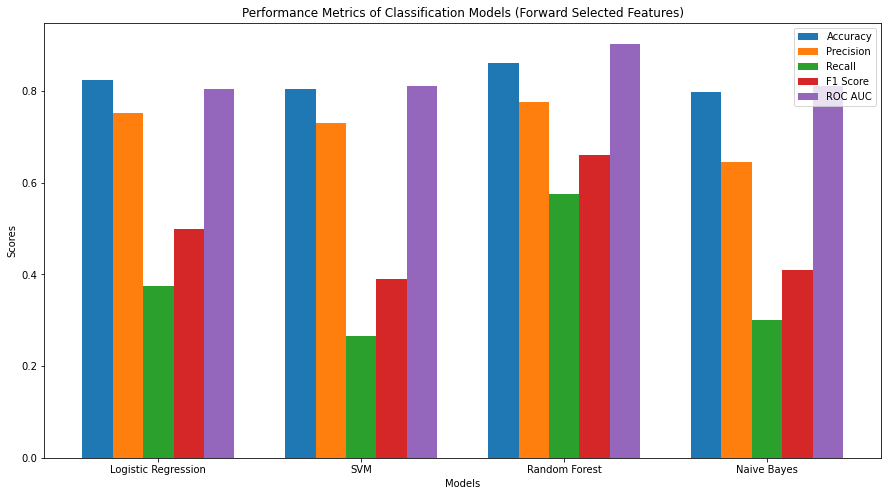

In [12]:
# Set up the figure and axis for forward selected features metrics
fig, ax = plt.subplots(figsize=(15, 8))

# Create an index for each tick position
ind = np.arange(len(forward_selected_metrics['Model']))

# Create the bar plot for each metric
bar_width = 0.15
b1 = ax.bar(ind - 2*bar_width, forward_selected_metrics['Accuracy'], bar_width, label='Accuracy')
b2 = ax.bar(ind - bar_width, forward_selected_metrics['Precision'], bar_width, label='Precision')
b3 = ax.bar(ind, forward_selected_metrics['Recall'], bar_width, label='Recall')
b4 = ax.bar(ind + bar_width, [f if f != 'N/A' else 0 for f in forward_selected_metrics['F1 Score']], bar_width, label='F1 Score')
b5 = ax.bar(ind + 2*bar_width, [r if r != 'N/A' else 0 for r in forward_selected_metrics['ROC AUC']], bar_width, label='ROC AUC')

# Describe the data
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Classification Models (Forward Selected Features)')
ax.set_xticks(ind)
ax.set_xticklabels(forward_selected_metrics['Model'])
ax.legend()

# Show the bar plot
plt.show()


In [ ]:
# backward selection 

In [13]:
# Function to perform backward feature selection
def backward_feature_selection(X_train, y_train, X_test, y_test, estimator):
    remaining_features = list(X_train.columns)
    best_acc = 0
    best_features = remaining_features.copy()
    
    while len(remaining_features) > 1:
        temp_acc = 0
        temp_feature = None
        
        for feature in remaining_features:
            temp_remaining_features = remaining_features.copy()
            temp_remaining_features.remove(feature)
            
            # Train the model using selected features
            estimator.fit(X_train[temp_remaining_features], y_train)
            
            # Evaluate the model on test data
            y_pred = estimator.predict(X_test[temp_remaining_features])
            acc = accuracy_score(y_test, y_pred)
            
            # Check if this feature removal improved the model's performance
            if acc > temp_acc:
                temp_acc = acc
                temp_feature = feature
        
        # If we found a feature that improved the model, remove it from the remaining features
        if temp_acc > best_acc:
            best_acc = temp_acc
            best_features = remaining_features.copy()
            best_features.remove(temp_feature)
            remaining_features.remove(temp_feature)
        else:
            break

    return best_features, best_acc

# Perform backward feature selection using Logistic Regression
best_features_backward, best_acc_backward = backward_feature_selection(X_train, y_train, X_test, y_test, LogisticRegression(random_state=42))

best_features_backward, best_acc_backward


In [ ]:
# ['age',
#   'workclass',
#   'education',
#   'education.num',
#   'marital.status',
#   'occupation',
#   'relationship',
#   'race',
#   'sex',
#   'capital.gain',
#   'capital.loss',
#   'native.country'],
#  0.81299938537185)

In [ ]:
# # Sample a subset of the training and testing data for faster computation
# X_train_subset = X_train.sample(frac=0.5, random_state=42)
# y_train_subset = y_train.loc[X_train_subset.index]
# X_test_subset = X_test.sample(frac=0.5, random_state=42)
# y_test_subset = y_test.loc[X_test_subset.index]

# # Perform backward feature selection using the subset and Logistic Regression
# best_features_backward_subset, best_acc_backward_subset = backward_feature_selection(
#     X_train_subset, y_train_subset, X_test_subset, y_test_subset, LogisticRegression(max_iter=1000, random_state=42))

# best_features_backward_subset, best_acc_backward_subset


In [16]:
# Initialize metrics storage for backward selected features
backward_selected_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
}

# Update the training and testing sets to include only the backward selected features
selected_features_backward = best_features_backward  # Renaming for clarity
X_train_backward = X_train[selected_features_backward]
X_test_backward = X_test[selected_features_backward]

# Perform k-fold cross-validation and evaluate metrics using backward selected features
for name, clf in classifiers.items():
    # Perform k-fold cross-validation
    cross_val_scores = cross_val_score(clf, X_train_backward, y_train, cv=5)
    cross_val_mean = cross_val_scores.mean()
    
    # Train the model
    clf.fit(X_train_backward, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test_backward)
    y_prob = clf.predict_proba(X_test_backward)[:, 1] if hasattr(clf, 'predict_proba') else None
    
    # Calculate performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    # Store metrics
    backward_selected_metrics['Model'].append(name)
    backward_selected_metrics['Accuracy'].append(acc)
    backward_selected_metrics['Precision'].append(prec)
    backward_selected_metrics['Recall'].append(rec)
    backward_selected_metrics['F1 Score'].append(f1)
    backward_selected_metrics['ROC AUC'].append(roc_auc)

# Create a DataFrame to display the metrics
backward_selected_metrics_df = pd.DataFrame(backward_selected_metrics)

backward_selected_metrics_df


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.812999   0.662032  0.407237  0.504277  0.809048
1                  SVM  0.805624   0.731397  0.265132  0.389184  0.826036
2        Random Forest  0.845114   0.682596  0.629605  0.655031  0.889904
3          Naive Bayes  0.800092   0.649795  0.312500  0.422035  0.847243

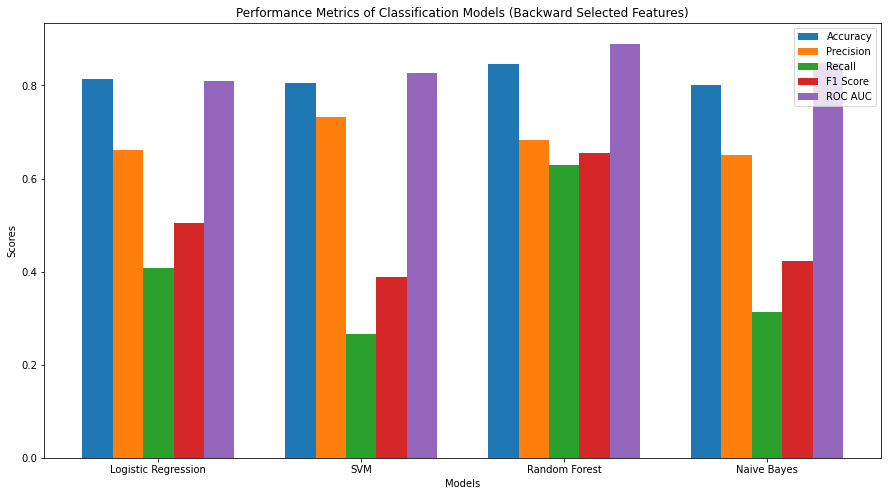

In [17]:
# Plotting the graph 
# Set up the figure and axis for backward selected features metrics
fig, ax = plt.subplots(figsize=(15, 8))

# Create an index for each tick position
ind = np.arange(len(backward_selected_metrics['Model']))

# Create the bar plot for each metric
bar_width = 0.15
b1 = ax.bar(ind - 2*bar_width, backward_selected_metrics['Accuracy'], bar_width, label='Accuracy')
b2 = ax.bar(ind - bar_width, backward_selected_metrics['Precision'], bar_width, label='Precision')
b3 = ax.bar(ind, backward_selected_metrics['Recall'], bar_width, label='Recall')
b4 = ax.bar(ind + bar_width, backward_selected_metrics['F1 Score'], bar_width, label='F1 Score')
b5 = ax.bar(ind + 2*bar_width, backward_selected_metrics['ROC AUC'], bar_width, label='ROC AUC')

# Describe the data
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Classification Models (Backward Selected Features)')
ax.set_xticks(ind)
ax.set_xticklabels(backward_selected_metrics['Model'])
ax.legend()

# Show the bar plot
plt.show()
